<h1><center>Rock Physics Modelling</center></h1>

This tutorial demonstrates how to create rock physics models and apply them to well logs to quantify seismic responses.

_Requirements:_

 - VP, VS, RHOB, PHI, VSH, IP logs
 
However, I had to generate VSH here since there was no VSH log available.

In [1]:
#Import libraries
from pyavo.seismodel import rpm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lasio

__1. Read & Explore well Data__

In [2]:
well_2 = lasio.read('./data/well_2.las')

In [3]:
well_2

In [4]:
print(well_2.curves)

Mnemonic  Unit  Value  Description                                                             
--------  ----  -----  -----------                                                             
DEPT      M                                                                                    
VP        KM/S         Vp                                                                      
VS        KM/S         Vs                                                                      
RHOB      G/C3         Bulk Density                                                            
GR        GAPI         Gamma Ray                                                               
NPHI      PU           Thermal Neutron Porosity (original Ratio Method) in Selected Lithology  


In [5]:
well_2.well.CTRY # Get well location

HeaderItem(mnemonic="CTRY", unit="", value="NORWAY", descr="Nation")

In [6]:
# Extract Depth, Vp, vs, density and GR form data
z_well = well_2['DEPT'] # depth
vp_well = well_2['VP'] * 1e3 # P-wave velocity convert to m/s
vs_well = well_2['VS'] * 1e3 # S-wave velocity convert to m/s
gr_well = well_2['GR'] # Gamma ray
rho_well = well_2['RHOB'] # Density
phi = well_2['NPHI']

#  Compute Vshale, vpvs and Acoustic impedance
vpvs_well = well_2['VP'] / well_2['VS'] # VpVs
ai = (well_2['VP']*1e3) * well_2['RHOB'] # Acoustic impedance

# clay content (%) = (GR - GRmin)/(GRmax - GRmin)
vsh = (gr_well - np.min(gr_well))/(np.max(gr_well) - np.min(gr_well)) # Vshale

__2. Alternatively, Compute porosity from fluid and mineral density__

In [7]:
# Parameters from Avseth et al. (2001) and Avseth et al. (2005)

# rho_qtz = 2.65 # Density of quartz mineral
# rho_fl = 1.05 # Density of fluid

# phi = (rho_qtz - rho_well)/(rho_qtz - rho_fl) # Porosity

__3. Normalize shale volume__

In [8]:
sand = 1 - vsh - phi
vsh_n = vsh/(vsh + sand)  

In [9]:
sand.shape # Get shape of ndarray

(4117,)

In [10]:
vsh_n.shape # Get shape of ndarray

(4117,)

Convert data array to Pandas Dataframe

In [11]:
well_dict = {  
    'DEPTH': z_well,
    'GR': gr_well,
    'RHOB': rho_well, 
    'VP': vp_well, 
    'VS': vs_well,
    'VPVS': vpvs_well,
    'IP': ai,
    'VSH': vsh_n,
    'PHI': phi
    }


well = pd.DataFrame(data=well_dict)

In [12]:
well.head()

,DEPTH,GR,RHOB,VP,VS,VPVS,IP,VSH,PHI
0,2013.2528,91.8785,1.9972,2294.7,876.9,2.616832,4582.97484,0.969405,0.4908
1,2013.4052,86.8004,2.0455,2296.7,943.0,2.435525,4697.89985,0.843836,0.4833
2,2013.5576,86.0021,2.1122,2290.4,912.5,2.510027,4837.78288,0.772626,0.4474
3,2013.7100,87.3570,2.1960,2277.5,891.6,2.554397,5001.39000,0.754820,0.4140
4,2013.8624,90.4024,2.2020,2262.0,890.5,2.540146,4980.92400,0.835596,0.4293


In [13]:
well.PHI.min()

0.0678

In [14]:
well.set_index('DEPTH').head() #Important

,GR,RHOB,VP,VS,VPVS,IP,VSH,PHI
DEPTH,,,,,,,,
2013.2528,91.8785,1.9972,2294.7,876.9,2.616832,4582.97484,0.969405,0.4908
2013.4052,86.8004,2.0455,2296.7,943.0,2.435525,4697.89985,0.843836,0.4833
2013.5576,86.0021,2.1122,2290.4,912.5,2.510027,4837.78288,0.772626,0.4474
2013.7100,87.3570,2.1960,2277.5,891.6,2.554397,5001.39000,0.754820,0.4140
2013.8624,90.4024,2.2020,2262.0,890.5,2.540146,4980.92400,0.835596,0.4293


In [15]:
print(well.VSH.min())
print(well.VSH.max())

0.0
1.8208302986161689


__4. Define model parameters__

In [16]:
vshale = well.VSH # Volume of shale
vp = well.VP # P-wave velocity
vs = well.VS # S-wave velocity
imp = well.IP # Acoustic impedance
poro = well.PHI # Porosity
rho = well.RHOB # Density
vpvs = well.VPVS #Vp/Vs

__5. Display key input logs for Rock Physics Modelling__

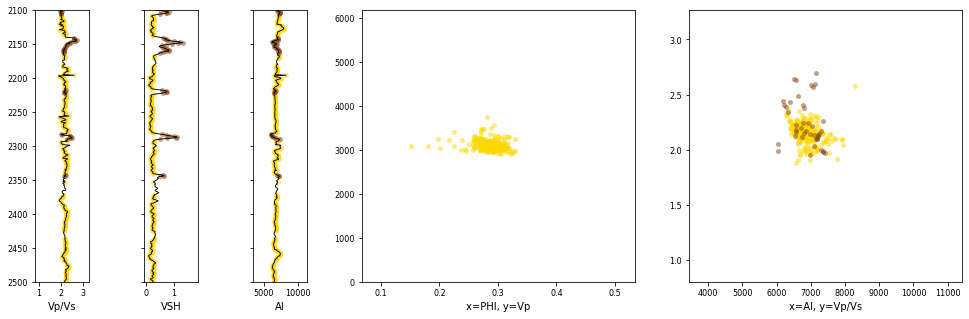

In [17]:
rpm.plot_log(well, vshale, vp, vs, imp, vpvs, poro, rho, 
             z_init=2100, z_final=2500, shale_cutoff=0.5, 
             sand_cutoff=0.3)

4. Compute Voigt-Reuss-Hill Avergae

In [18]:
# Data
rho_qtz = 2.6 # Density of quartz
k_qtz = 37 # Bulk modulus of quartz
mu_qtz = 44 # Shear modulus of quartz
rho_sh = 2.8 # Denisty of shale
k_sh = 15 # Bulk modulus of shale
mu_sh = 5 # Shear modulus of shale
rho_br = 1.1 # Density of brine
k_br = 2.8 # Bulk modulus of brine
rho_o = 0.8 # Density of oil
k_o = 0.9 # Bulk modulus of oil
rho_g = 0.2 # Density of gas
k_g = 0.06 # Bulk modulus of gas
phic = 0.4 #Critical porosity
f = 1

phi = np.linspace(0.001, 0.4) # porosity 
NG = np.linspace(0.5, 1.0, 5) # Net to Gross

z1, z2, cutoff_sand, cutoff_shale = 2100, 2550, 0.3, 0.5 

P, cp_ssm, cn_ssm, cp_stm, cn_stm = 45, 0.5, 15, 0.4, 9 # Adjust coordination number to fit desired model

eff_phi = well.PHI

In [19]:
rpm.voigt_reuss(mod1=k_qtz,mod2=k_sh,vfrac=0.8) #Bulk modulus

(32.6, 28.608247422680414, 30.604123711340208)

In [20]:
rpm.voigt_reuss(mod1=mu_qtz,mod2=mu_sh,vfrac=0.8) #Shear modulus 

(36.2, 17.1875, 26.69375)

5. Plot Soft and Stiff Sand Rock Physics Models for different mineralogies

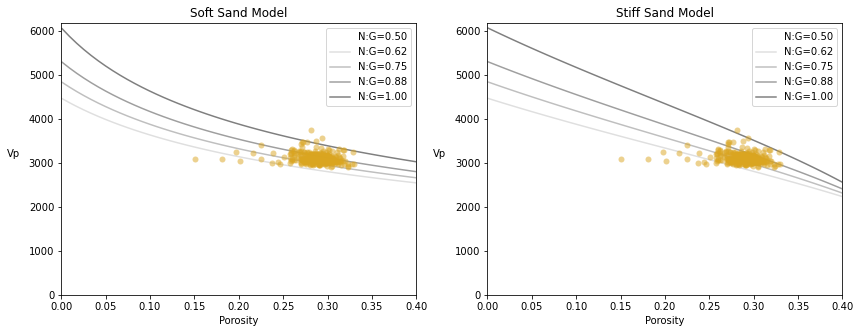

In [21]:
rpm.plot_rpm(well, k_qtz, mu_qtz, k_sh, mu_sh, rho_sh, rho_qtz, 
             k_br, rho_br, phi, NG, vshale, z1, z2, cutoff_sand, 
             cutoff_shale, P, cp_ssm, cn_ssm, cp_stm, cn_stm, eff_phi, vp)

__6. Explore plot of Rock Physics Template__

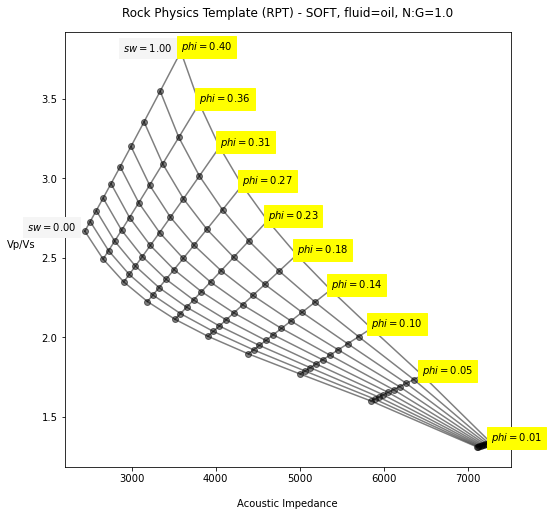

In [22]:
ip, vpvs = rpm.plot_rpt(model='soft', fluid='oil') #Soft sand model, fluid=oil

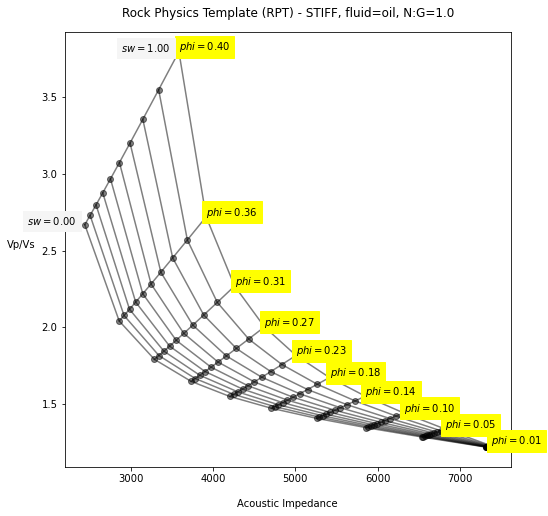

In [23]:
ip, vpvs = rpm.plot_rpt(model='stiff', fluid='oil') #Stiff sand model, fluid=oil

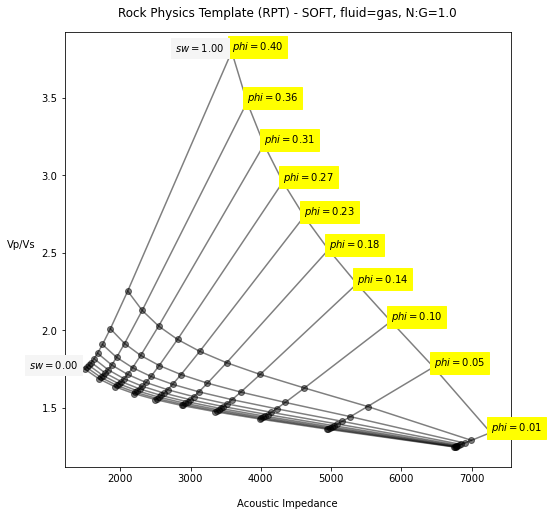

In [24]:
ip, vpvs = rpm.plot_rpt(model='soft', fluid='gas') #Soft sand model, fluid=gas

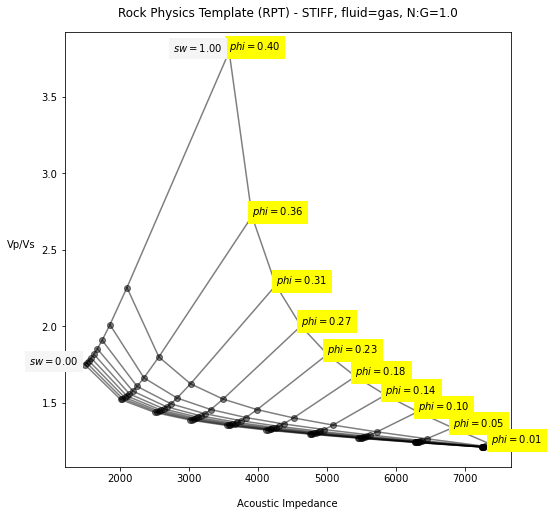

In [25]:
ip, vpvs = rpm.plot_rpt(model='stiff', fluid='gas') #Stiff sand model, fluid=gas

__7. Generate RPT for stiff oil sand model using non-default parameters__

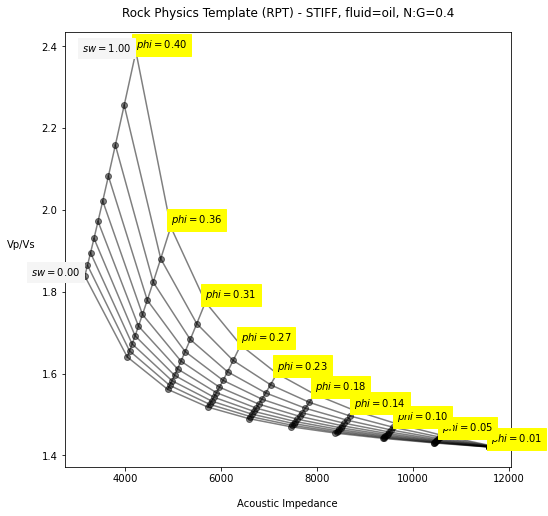

In [26]:
ip_oil, vpvs_oil = rpm.plot_rpt(model='stiff', vsh=0.6, fluid='oil', 
                            cp=0.4, cd_num=8, P=45, f=.3)

__8. Superimpose plots of Soft and Stiff Sand RPT models on well data.__

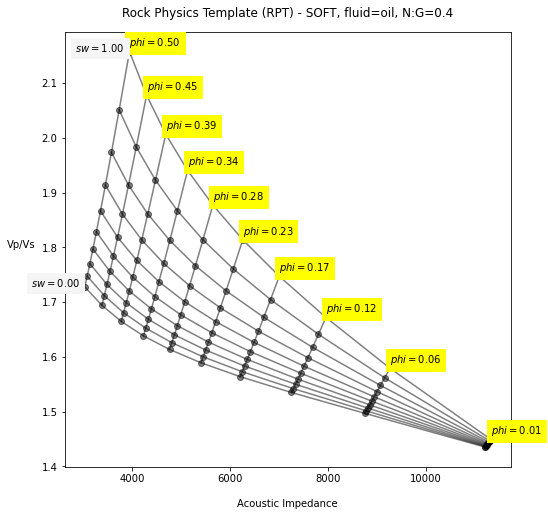

In [27]:
ip_rpt0, vpvs_rpt0 = rpm.plot_rpt(model='soft',vsh=0.6,
                         fluid='oil',cp=0.5,
                         cd_num=12, P=45, f=.3)

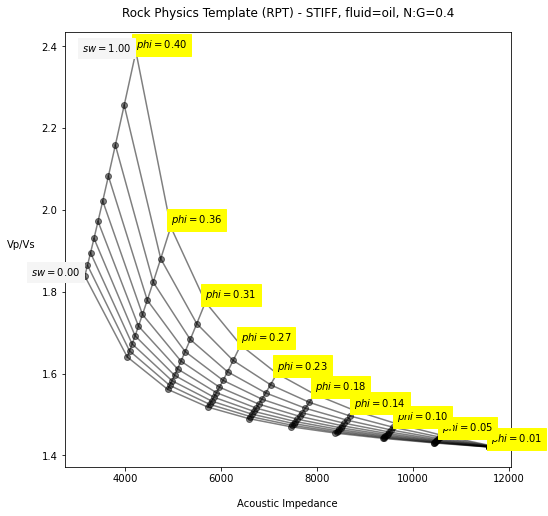

In [28]:
ip_rpt1, vpvs_rpt1 = rpm.plot_rpt(model='stiff',vsh=0.6,
                         fluid='oil',cp=0.4,
                         cd_num=8, P=45, f=.3)

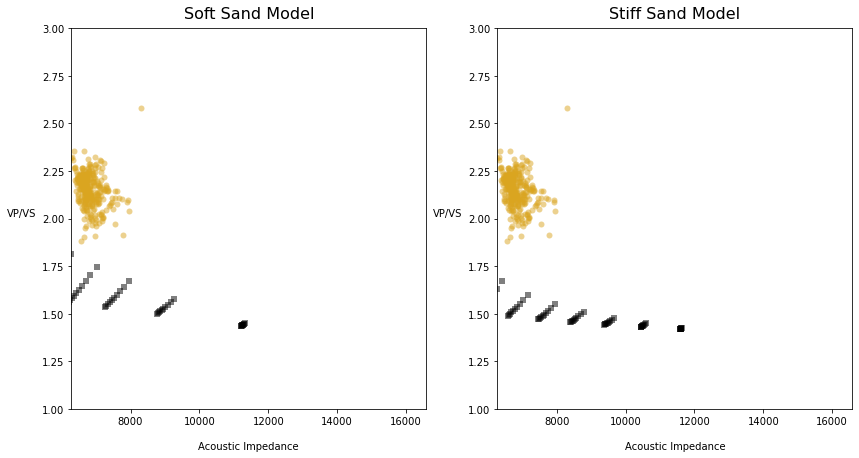

In [29]:
rpm.well_rpt(well, z1, z2, cutoff_sand, vshale, vp, vs, 
             rho, ip_rpt0, vpvs_rpt0, ip_rpt1, vpvs_rpt1)

__7. Display seismic signatures at Near and Far offset traces and AVO curve__

In [30]:
top_lyr = 2400
z0 = top_lyr - 50
z1 = top_lyr
z2 = top_lyr + 50
z = well.index # Depth

sand = (z>=z1) & (z<=z2) # Sand line
shale = (z>=z0) & (z<=z1) # Shale line

# Average elastic properties from two fairly regular intervals above and below top reservoir 
vp1, vs1, rho1 = well[['VP','VS','RHOB']][shale].mean().values
vp2, vs2, rho2 = well[['VP','VS','RHOB']][sand].mean().values

# Display no of samples
samples_sh = np.isfinite(well.index[shale]).size
samples_ss = np.isfinite(well.index[sand]).size

print('({:>4.0f}-{:<4.0f}m,{:3d} samples) Vp={:.0f}, Vs={:.0f}, rho={:.2f}, Ip={:.0f}, Vp/Vs={:.2f} '.format(z0,z1,samples_sh,vp1,vs1,rho1,vp1*rho1,vp1/vs1))
print('({:>4.0f}-{:<4.0f}m,{:3d} samples) Vp={:.0f}, Vs={:.0f}, rho={:.2f}, Ip={:.0f}, Vp/Vs={:.2f} '.format(z1,z2,samples_ss,vp2,vs2,rho2,vp2*rho2,vp2/vs2))


(2350-2400m, 51 samples) Vp=3102, Vs=1476, rho=2.21, Ip=6843, Vp/Vs=2.10 
(2400-2450m, 51 samples) Vp=3056, Vs=1406, rho=2.18, Ip=6653, Vp/Vs=2.17 


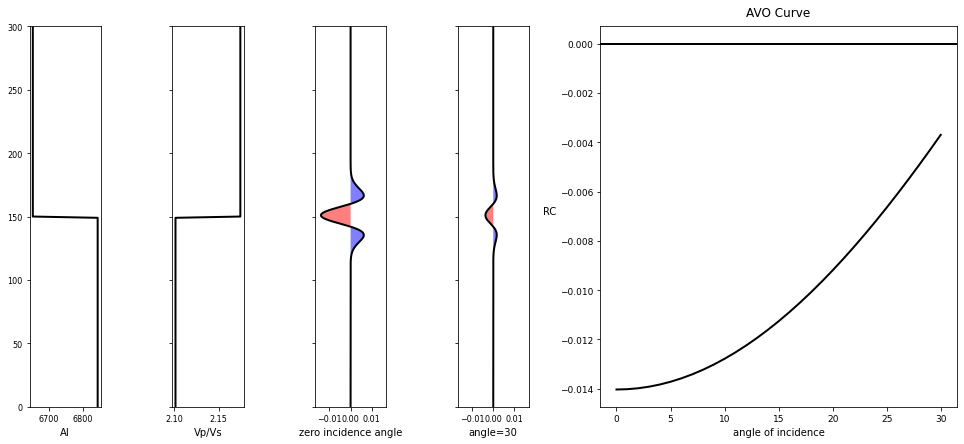

In [31]:
rpm.twolayer(300, vp1, vs1, rho1, vp2, vs2, rho2)

__Further Reading:__
    
https://nbviewer.jupyter.org/github/aadm/geophysical_notes/blob/master/rock_physics_modeling.ipynb

The dataset: https://srb.stanford.edu/quantitative-seismic-interpretation

Avseth, P., Mukerji, T. & Mavko, G.: Quantitative Seismic Interpretation. (Cambridge University Press, 2005).

Dvorkin, J., Gutierrez, M. and Grana, D.: Seismic Reflections of Rock Properties. (Cambridge University Press, 2012?).

Mavko, G., Mukerji, T. & Dvorkin, J.: The Rock Physics Handbook. (Cambridge University Press, 2009).